In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Vamos a calcular el omega bar pero con el elipsoide  calculado en elipsoide_barra

## M31gd

In [4]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength2 as strng
from numpy import matrix
import tenform as ten
from numpy import linalg

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

atime = np.loadtxt('/home/ornela/SimCLUES/redshift_outputs.txt')
aexp = atime[:,2]

data = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/M31_lbarvstime.dat')
lbar1 = data[:,1]
lbar2 = data[:,2]

snapshot=range(496,250,-1) #SNAPSHOTS
i = 0
for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/SimCLUES/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.


    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    
#-----------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
#--------------------------------------------------------------------------------------    

    corte, = np.where(r<3*aexp[isnap])
    
    A2max, rmax, phi = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)
    
    #Hacemos la rotación de las coordenadas
    xx = xn*cos(phi)+yn*sin(phi)
    yy = xn*-sin(phi)+yn*cos(phi)
    zz = zn
    
    
    #----para lbar1--------------------------------------------------------------
    limit1,=np.where(r < lbar1[0])
    tensor = ten.tenf(xx[limit1], yy[limit1], zz[limit1])

    matriz = linalg.eig(tensor)
    autov  = matriz[0]

    asort  = np.sort(autov)

    a1 = asort[2]
    b1 = asort[1]
    c1 = asort[0]

    A1 = np.sqrt(a1)
    B1 = np.sqrt(b1)
    C1 = np.sqrt(c1)

    
#Definimos el tamaño de nuestro elipsoide
    aa=lbar1[i]
    bb=(B1/A1)*lbar1[i]
    cc=(C1/A1)*lbar1[i]
    
    RR = np.sqrt((xx/aa)**2+(yy/bb)**2+(zz/cc)**2) # formula del elipsoide
    mask, = np.where(RR<1) #seleccionamos las particulas dentro del elipsoide
    
    xn1   = xn[mask]
    yn1   = yn[mask]
    zn1   = zn[mask]
    vxn1  = vxn[mask]
    vyn1  = vyn[mask]
    vzn1  = vzn[mask]
    mstr1 = mstr[mask]
    
    rcil = np.sqrt(xn1**2 + yn1**2)
    
    mask2, = np.where((rcil>0.8*aa) & (rcil<aa)) #tomamos las particulas de la punta del elipsoide

#Calculamos las componentes de momento angular
    Lx = sum((yn1[mask2]*vzn1[mask2] - zn1[mask2]*vyn1[mask2]) * mstr1[mask2])
    Ly = sum((zn1[mask2]*vxn1[mask2] - xn1[mask2]*vzn1[mask2]) * mstr1[mask2])
    Lz = sum((xn1[mask2]*vyn1[mask2] - yn1[mask2]*vxn1[mask2]) * mstr1[mask2])

#Calculamos las componentes del tensor de inercia
    Ixx = sum(mstr1[mask2] * (yn1[mask2]**2 + zn1[mask2]**2))
    Ixy = sum(mstr1[mask2] * xn1[mask2] * yn1[mask2])
    Ixz = sum(mstr1[mask2] * xn1[mask2] * zn1[mask2])
    Iyy = sum(mstr1[mask2] * (xn1[mask2]**2 + zn1[mask2]**2))
    Iyz = sum(mstr1[mask2] * yn1[mask2] * zn1[mask2])
    Izz = sum(mstr1[mask2] * (xn1[mask2]**2 + yn1[mask2]**2))
    
    II = matrix([[Ixx,Ixy,Ixz],[Ixy, Iyy, Iyz], [Ixz, Iyz, Izz]]) #matriz del tensor de inercia
    
    Iinv = II.I #Invertimos la matriz

    omega = Iinv[2,0]*Lx +Iinv[2,1]*Ly + Iinv[2,2]*Lz #velocidad angular del elipsoide
    
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#Lo mismo que arriba pero usamos todas las particulas del elipsoide

#Calculamos las componentes de momento angular
    Lx_total = sum((yn1*vzn1 - zn1*vyn1) * mstr1)
    Ly_total = sum((zn1*vxn1 - xn1*vzn1) * mstr1)
    Lz_total = sum((xn1*vyn1 - yn1*vxn1) * mstr1)

#Calculamos las componentes del tensor de inercia
    Ixx_total = sum(mstr1 * (yn1**2 + zn1**2))
    Ixy_total = sum(mstr1 * xn1 * yn1)
    Ixz_total = sum(mstr1 * xn1 * zn1)
    Iyy_total = sum(mstr1 * (xn1**2 + zn1**2))
    Iyz_total = sum(mstr1 * yn1 * zn1)
    Izz_total = sum(mstr1 * (xn1**2 + yn1**2))
    
    II_total = matrix([[Ixx_total ,Ixy_total,Ixz_total],
                       [Ixy_total, Iyy_total, Iyz_total], 
                       [Ixz_total, Iyz_total, Izz_total]]) #matriz del tensor de inercia
    
    Iinv_total = II_total.I #Invertimos la matriz

#velocidad angular del elipsoide
    omega_total = Iinv_total[2,0]*Lx_total + Iinv_total[2,1]*Ly_total + Iinv_total[2,2]*Lz_total 


# otra forma -----------------------------------------------------------------------------    
#     detI = Ixx*Iyy*Izz + 2*Ixy*Iyz*Ixz - Iyy*Ixz**2 - Ixx*Iyz**2 - Izz*Ixy**2
#     print detI
    
#     a13 = (Ixy*Iyz-Ixz*Iyy)/detI
#     a23 = (Ixz*Ixy-Iyz*Ixx)/detI
#     a33 = (Ixx*Iyy-Ixy**2)/detI
#     print a33
    #omegaz = median(Lz/Izz)
#     print omegaZ
    
#     omega2 = (xn[mask]*vyn[mask] - yn[mask]*vxn[mask])/rcil[mask]**2
#     omega3 = median(omega2)
    
#     VT =(xn[mask]*vyn[mask] - yn[mask]*vxn[mask])/rcil[mask]
#--------------------------------------------------------------------------------------

#Guargamos los parámetros en distintos archivos
#-------------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/omegabar_time_test.dat','a')
    archivo1.write(str('%03d'% isnap) +'\t'+
               str('%12.6f'% time) +'\t'+
               str('%12.6f'% omega) +'\n')
    archivo1.close()
    
#     archivo2 =  open('/home/ornela/python/barras/total_omegabar_time2.dat','a')
#     archivo2.write(str('%03d'% isnap) +'\t'+
#                str('%12.6f'% time) +'\t'+
#                str('%12.6f'% omega_total) +'\n')
#     archivo2.close()
#--------------------------------------------------------------------------------------
    i += 1


In [5]:
cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd_/barras/new_phi_time.dat')
time =cm[:,1]
phi =cm[:,2]

kk = len(phi)-1

delta_phi = np.zeros(len(phi))
delta_t = np.zeros(len(phi))
tt = np.zeros(len(phi))

for i in range(kk,0,-1):
    delta_t [i]  = time[i-1] - time[i]
    delta_phi[i] = phi[i-1] - phi[i]
    tt[i] = (time[i-1] + time[i]) / 2.

delta_t   = delta_t[1:]
delta_phi = delta_phi[1:]
tt = tt[1:]

veloc_ang = delta_phi/delta_t


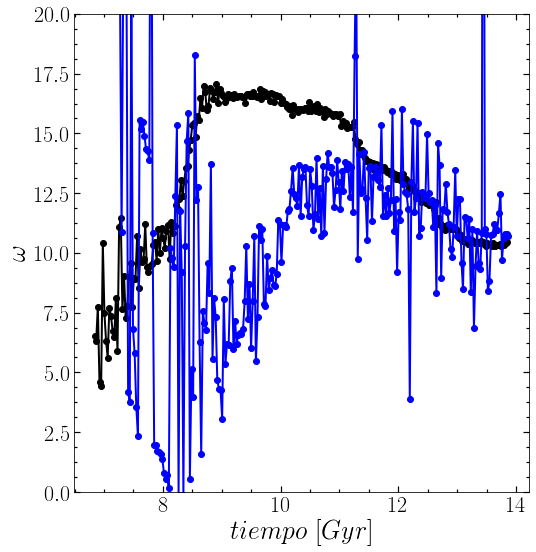

In [9]:
from __future__ import unicode_literals
import matplotlib.patches as patches

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


cm1=np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/omegabar_time_test.dat')
t1 =cm1[:,1]
omega1 =cm1[:,2]

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(tt,veloc_ang/360.,'ko-', lw=2)
ax.plot(t1,omega1/(2.*pi),'bo-', lw=2)
#ax3.set_xlim(7.5,14)
ax.set_ylim(0,20)
ax.minorticks_on()
ax.tick_params( labelsize=22)
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')  
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26)
ax.set_ylabel(r'$\omega$',fontsize=26)
#ax3.twinx() #me hace un eje del otro lado
#ax3.axis('square') #hace el plot cuadrado
#ax3.set_axisbelow(True)
plt.show()
